# IMDB Classification: RNN (with GRU/Global Max Pooling) vs. Naive Bayes

This notebook loads and processes the IMDB dataset, builds a custom vocabulary, and creates two types of representations:

- **Tokenized sequences** for training RNN models (RNN, GRU, LSTM with Global Max Pooling).
- **Bag-of-Words binary representation** for a Naive Bayes classifier (BernoulliNB).

After training, we compare the performance of the RNN models and Naive Bayes on test data by reporting accuracy, precision, recall, and F1 scores.

In [1]:
# Import necessary libraries
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.datasets import imdb
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import re
import string

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cpu


## Parameters

Set basic parameters for the vocabulary and dataset.

In [2]:
# Set parameters
m = 1000  # Number of words in vocabulary
n = 20    # N most frequent words to skip
k = 0     # K least frequent words to skip

## Load IMDB Dataset and Create Index-to-Word Mapping

Load the dataset using Keras and create a mapping to convert tokenized sequences back to text.

In [3]:
# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=m-k, skip_top=n)
word_index = imdb.get_word_index()

# Create index-to-word mapping
index2word = {i + 3: word for word, i in word_index.items()}
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'


## Convert Tokenized Sequences Back to Text

Transform the numerical sequences into readable text.

In [4]:
x_train = [' '.join([index2word.get(idx, '[oov]') for idx in text]) for text in x_train]
x_test = [' '.join([index2word.get(idx, '[oov]') for idx in text]) for text in x_test]

## Split Training Set into Training and Validation Sets

Use scikit-learn to split the training data into training and validation subsets.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

## Create Custom Vocabulary using CountVectorizer

Fit a `CountVectorizer` on the training text to build a vocabulary. Special tokens are added manually.

In [6]:
vectorizer = CountVectorizer(max_features=m, binary=True)
vectorizer.fit(X_train)
custom_vocab = vectorizer.vocabulary_

# Ensure special tokens are in the vocabulary
custom_vocab['PAD'] = len(custom_vocab)
custom_vocab['UNK'] = len(custom_vocab)


## Compute Average Sequence Length

Calculate the average length of the tokenized text (after removing non-alphabetical characters).

In [7]:
avg_length = int(np.mean([len(re.sub(r'[^a-zA-Z]', ' ', text.lower()).split()) for text in X_train]))
print('Average sequence length:', avg_length)

Average sequence length: 241


## Convert Text Data into Binary Bag-of-Words Representation

Transform the text into a binary bag-of-words representation using the fitted vectorizer. This representation will be used for the Naive Bayes classifier.

In [8]:
X_train_binary = torch.tensor(vectorizer.transform(X_train).toarray(), dtype=torch.float64)
X_val_binary = torch.tensor(vectorizer.transform(X_val).toarray(), dtype=torch.float64)
X_test_binary = torch.tensor(vectorizer.transform(x_test).toarray(), dtype=torch.float64)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

## Create DataLoader for Bag-of-Words Data (Naive Bayes)

Wrap the bag-of-words data into PyTorch datasets and create DataLoaders.

In [9]:
train_dataset = TensorDataset(X_train_binary, y_train)
val_dataset = TensorDataset(X_val_binary, y_val)
test_dataset = TensorDataset(X_test_binary, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Vocabulary size: {len(custom_vocab)}')

Training samples: 20000
Validation samples: 5000
Test samples: 25000
Vocabulary size: 955


## Define Dataset Class for Tokenized Text (for RNN Models)

This custom Dataset tokenizes each text using the custom vocabulary and pads/truncates to a fixed maximum length.

In [10]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length):
        self.texts = [self.tokenize(text, vocab, max_length) for text in texts]
        self.labels = labels

    def tokenize(self, text, vocab, max_length):
        text = re.sub(r'[^a-zA-Z]', ' ', text.lower()).split()
        tokens = [vocab.get(word, vocab['UNK']) for word in text]
        if len(tokens) < max_length:
            tokens += [vocab['PAD']] * (max_length - len(tokens))
        else:
            tokens = tokens[:max_length]
        return tokens

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

## Create DataLoaders for Tokenized Text Data (for RNN Models)

Wrap the tokenized data into a dataset and create DataLoaders.

In [11]:
train_dataset = TextDataset(X_train, y_train, custom_vocab, avg_length)
val_dataset = TextDataset(X_val, y_val, custom_vocab, avg_length)
test_dataset = TextDataset(x_test, y_test, custom_vocab, avg_length)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


## Define RNN Models (RNN, GRU, LSTM) with Global Max Pooling

Here we define a model class that can instantiate an RNN, GRU, or LSTM with global max pooling.

In [12]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size,
                 embed_dim, hidden_dim, output_dim,
                 model_type='RNN',
                 pretrained=True, freeze=False,
                 use_pooling=True,  # Global max pooling enabled
                 num_layers=2, bidirectional=True):
        super(RNNModel, self).__init__()
        self.use_pooling = use_pooling
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim

        # Initialize embeddings
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Select the RNN variant (RNN, GRU, or LSTM)
        rnn_class = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[model_type]
        self.rnn = rnn_class(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Adjust fully connected layer input dimension
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embed_dim)
        output, _ = self.rnn(embedded)  # (batch_size, seq_length, hidden_dim*(2 if bidirectional else 1))

        if self.use_pooling:
            # Global max pooling over the sequence dimension
            pooled = torch.max(output, dim=1)[0]  
            return torch.sigmoid(self.fc(pooled))
        else:
            return torch.sigmoid(self.fc(output[:, -1, :]))


## Define Training Function

Train the model over a given number of epochs and record the training and validation loss.

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for texts, labels in train_loader:
            optimizer.zero_grad()
            texts = texts.to(device)
            labels = labels.float().to(device)
            outputs = model(texts).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts = texts.to(device)
                labels = labels.float().to(device)
                outputs = model(texts).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        if epoch % 2 == 0:
            print(f'Epoch: {epoch:4.0f} / {epochs} | Training Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}')
    
    return train_losses, val_losses


## Define Evaluation Function

Evaluate the model on the test set and compute accuracy, precision, recall, and F1 score.

In [14]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            preds = model(texts).squeeze() > 0.5
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1


## Instantiate and Train RNN Models (RNN, GRU, LSTM)

We create three models and train each one, then record the training/validation loss and evaluation metrics on the test set.

Training RNN...


C:\Users\thana\AppData\Local\Temp\ipykernel_3488\2034065737.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])


Epoch:    0 / 10 | Training Loss: 160.42703, Validation Loss: 31.86712
Epoch:    2 / 10 | Training Loss: 102.08426, Validation Loss: 29.84438
Epoch:    4 / 10 | Training Loss: 77.62261, Validation Loss: 31.77663
Epoch:    6 / 10 | Training Loss: 54.52437, Validation Loss: 33.34792
Epoch:    8 / 10 | Training Loss: 30.58068, Validation Loss: 37.12949
Training GRU...


C:\Users\thana\AppData\Local\Temp\ipykernel_3488\2034065737.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])


Epoch:    0 / 10 | Training Loss: 154.74397, Validation Loss: 34.53899
Epoch:    2 / 10 | Training Loss: 82.11717, Validation Loss: 27.84201
Epoch:    4 / 10 | Training Loss: 43.46538, Validation Loss: 34.63543
Epoch:    6 / 10 | Training Loss: 13.45945, Validation Loss: 49.74955
Epoch:    8 / 10 | Training Loss: 3.42296, Validation Loss: 71.19048
Training LSTM...


C:\Users\thana\AppData\Local\Temp\ipykernel_3488\2034065737.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])


Epoch:    0 / 10 | Training Loss: 159.81381, Validation Loss: 31.00045
Epoch:    2 / 10 | Training Loss: 78.27442, Validation Loss: 30.51847
Epoch:    4 / 10 | Training Loss: 35.86514, Validation Loss: 38.01303
Epoch:    6 / 10 | Training Loss: 10.13005, Validation Loss: 55.26645
Epoch:    8 / 10 | Training Loss: 7.64319, Validation Loss: 63.98763


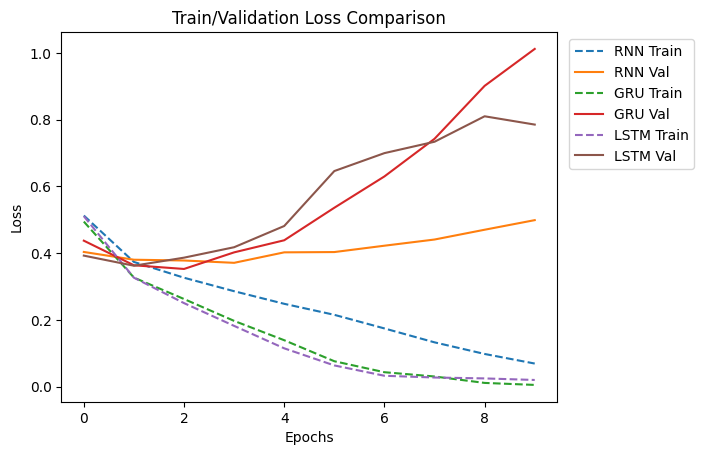

RNN: Accuracy=0.8391, Precision=0.8595, Recall=0.8106, F1=0.8344
GRU: Accuracy=0.8389, Precision=0.8383, Recall=0.8398, F1=0.8390
LSTM: Accuracy=0.8368, Precision=0.8293, Recall=0.8482, F1=0.8386


In [15]:
models = {
    'RNN': RNNModel(len(custom_vocab), 300, 64, 1, 'RNN',
                    use_pooling=True, num_layers=2, bidirectional=True),
    'GRU': RNNModel(len(custom_vocab), 300, 64, 1, 'GRU',
                    use_pooling=True, num_layers=2, bidirectional=True),
    'LSTM': RNNModel(len(custom_vocab), 300, 64, 1, 'LSTM',
                     use_pooling=True, num_layers=2, bidirectional=True)
}

results = {}
epochs = 10

for name, model in models.items():
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {name}...")
    train_losses, val_losses = train_model(model.float().to(device), train_loader, val_loader,
                                           criterion, optimizer, epochs=epochs)
    results[name] = {'train_loss': train_losses, 'val_loss': val_losses}
    acc, prec, rec, f1 = evaluate_model(model, test_loader)
    results[name].update({'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})

# Plot training and validation losses
for name in models:
    plt.plot(results[name]['train_loss'], linestyle='--', label=f'{name} Train')
    plt.plot(results[name]['val_loss'], label=f'{name} Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Validation Loss Comparison')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

# Print evaluation metrics for each model
for name, metrics in results.items():
    print(f"{name}: Accuracy={metrics['accuracy']:.4f}, Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")


```plaintext
Output:
cpu
cpu
Training samples: 20000
Validation samples: 5000
Test samples: 25000     
Vocabulary size: 955    
Training RNN...
Epoch:    0 / 10 | Training Loss: 164.45803, Validation Loss: 32.73606
Epoch:    2 / 10 | Training Loss: 102.47885, Validation Loss: 28.72308
Epoch:    4 / 10 | Training Loss: 76.53272, Validation Loss: 30.31154
Epoch:    6 / 10 | Training Loss: 51.84893, Validation Loss: 31.30217
Epoch:    8 / 10 | Training Loss: 29.06599, Validation Loss: 35.54264
Training GRU...
Epoch:    0 / 10 | Training Loss: 155.78530, Validation Loss: 30.41802
Epoch:    2 / 10 | Training Loss: 81.56101, Validation Loss: 28.66211
Epoch:    4 / 10 | Training Loss: 42.58857, Validation Loss: 38.59015
Epoch:    6 / 10 | Training Loss: 11.54743, Validation Loss: 56.28524
Epoch:    8 / 10 | Training Loss: 5.88370, Validation Loss: 69.25617
Training LSTM...
Epoch:    0 / 10 | Training Loss: 155.47545, Validation Loss: 32.04157
Epoch:    2 / 10 | Training Loss: 77.85037, Validation Loss: 28.94105
Epoch:    4 / 10 | Training Loss: 36.44361, Validation Loss: 39.11787
Epoch:    6 / 10 | Training Loss: 14.38555, Validation Loss: 48.93268
Epoch:    8 / 10 | Training Loss: 7.20283, Validation Loss: 59.62413
RNN: Accuracy=0.8348, Precision=0.8357, Recall=0.8335, F1=0.8346
GRU: Accuracy=0.8421, Precision=0.8493, Recall=0.8317, F1=0.8404
LSTM: Accuracy=0.8394, Precision=0.8201, Recall=0.8696, F1=0.8441


![](AI_Project_IMDB/NaiveBayes/RNN/RNN_Curves.png)


## End of Notebook

This notebook demonstrated the process of training and comparing RNN-based models with a Naive Bayes classifier on the IMDB dataset. Next steps might include further hyperparameter tuning and additional evaluations.